# Wavelet analysis SIE: 
  
## Figure 8 and S5
  
Katie Brennan  
January 2020

In [1]:
import numpy as np
import xarray as xr
from waveletFunctions import wavelet, wave_signif, wave_bases
import matplotlib.pylab as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.ticker import StrMethodFormatter, NullFormatter

In [2]:
def plot_cwt(fig, ax, time, period, power, sig95, coi, title, levels, cmap='GnBu'):
    cmap = plt.cm.get_cmap(cmap)
    
    ls = [n/(len(levels)-2) for n in range(len(levels))]

    CS = ax.contourf(time, period, power, levels, 
                     colors = [cmap(n) for n in ls])  #*** or use 'contour'

    #ax.set_xlabel('Time (year)', fontsize=14)
    ax.set_ylabel('Period (years)', fontsize=14)
    ax.set_title(title, fontsize=16, loc='right')
    ax.set_xlim([time.min(),time.max()])

    # 95# significance contour, levels at -99 (fake) and 1 (95# signif)
    ax.contour(time, period, sig95, [-99, 1], colors='k')

    # cone-of-influence, anything "below" is dubious
    ax.plot(time, coi, 'k')
    ax.fill_between(time,coi,y2=period.max(),color='k', alpha=0.5)

    # format y-scale
    ax.set_yscale('log', basey=2, subsy=None) #
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax.yaxis.set_minor_formatter(NullFormatter())
#     ax_x = plt.gca().yaxis
#     ax.set_major_formatter(ticker.ScalarFormatter())
#    ax.ticklabel_format(axis='y', style='plain') #

    ax.set_ylim([period.min(), 500])
    ax.invert_yaxis()
    
    return CS

def get_cwt(data,time,dt,pad,dj,s0,j1,mother,lag1,param=-1):
    n = len(data)
    
    variance = np.std(data, ddof=1) ** 2
    
    # Wavelet transform:
    wave, period, scale, coi = wavelet(data, dt, pad, dj, s0, j1, mother, param=param)
    power = (np.abs(wave)) ** 2  # compute wavelet power spectrum
    global_ws = (np.sum(power, axis=1) / n)  # time-average over all times
    
    # Significance levels:
    signif = wave_signif(([variance]), dt=dt, sigtest=0, scale=scale,lag1=lag1, mother=mother)
    sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])  # expand signif --> (J+1)x(N) array
    sig95 = power / sig95  # where ratio > 1, power is significant
    
    return period, power, sig95, coi, time

def calc_lac(fcast, obs):
    """
    Method to calculate the Local Anomaly Correlation (LAC).  Uses numexpr
    for speed over larger datasets.

    Note: If necessary (memory concerns) in the future, the numexpr statements
    can be extended to use pytable arrays.  Would need to provide means to
    function, as summing over the dataset is still very slow it seems.

    Parameters
    ----------
    fcast: ndarray
        Time series of forecast data. M x N where M is the temporal dimension.
    obs: ndarray
        Time series of observations. M x N

    Returns
    -------
    lac: ndarray
        Local anomaly corellations for all locations over the time range.
    """
    # Calculate means of data
    f_mean = fcast.mean(axis=0)
    o_mean = obs.mean(axis=0)
    f_anom = fcast - f_mean
    o_anom = obs - o_mean
    
    # Calculate covariance between time series at each gridpoint
    cov = (f_anom * o_anom).sum(axis=0)

    # Calculate standardization terms
    f_std = (f_anom**2).sum(axis=0)
    o_std = (o_anom**2).sum(axis=0)
#     if is_dask_array(f_std):
#         f_std = da.sqrt(f_std)
#     else:
#         f_std = np.sqrt(f_std)

#     if is_dask_array(o_std):
#         o_std = da.sqrt(o_std)
#     else:
#         o_std = np.sqrt(o_std)
    f_std = np.sqrt(f_std)
    o_std = np.sqrt(o_std)
    
    std = f_std * o_std
    lac = cov / std

    return lac

In [3]:
plt.rcParams['figure.dpi']=300

## Load reconstructed sea ice data: 

In [4]:
anom_start = 1900
anom_end = 1940

In [5]:
recon_dir = '/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/data/'
recon_file_ccsm4 = 'Brennan_and_Hakim_2021_CCSM4_model_prior_reconstructions_nh.nc'
recon_fixed = 'Brennan_and_Hakim_2021_CCSM4_fixed_proxy_reconstructions_nh.nc'

recon_data_ccsm4 = xr.open_dataset(recon_dir+recon_file_ccsm4)
recon_data_fixed = xr.open_dataset(recon_dir+recon_fixed)

In [6]:
sie_ccsm4_anom = recon_data_ccsm4.si_extent_anomalies.values
sie_ccsm4_anom_2d = np.reshape(sie_ccsm4_anom,(2000,2000))
sie_ensmn_anom_ccsm4 = recon_data_ccsm4.si_extent_ensemble_mean_anomalies.values
sie_ccsm4_97_5_anom = recon_data_ccsm4.si_extent_97_5_percentiles.values
sie_ccsm4_2_5_anom = recon_data_ccsm4.si_extent_2_5_percentiles.values
recon_years = recon_data_ccsm4.time.values

In [7]:
anom_ind = np.where((recon_years>=anom_start)&(recon_years<anom_end+1))
sie_ensmn_anom_ccsm4_full = sie_ensmn_anom_ccsm4 - np.nanmean(sie_ensmn_anom_ccsm4[anom_ind],axis=0)
sie_ccsm4_97_5_anom_full = sie_ccsm4_97_5_anom - np.nanmean(sie_ensmn_anom_ccsm4[anom_ind],axis=0)
sie_ccsm4_2_5_anom_full = sie_ccsm4_2_5_anom - np.nanmean(sie_ensmn_anom_ccsm4[anom_ind],axis=0)

In [8]:
sie_fixed_anom = recon_data_fixed.si_extent_anomalies.values
sie_ensmn_anom_fixed = recon_data_fixed.si_extent_ensemble_mean_anomalies.values
sie_fixed_97_5_anom = recon_data_fixed.si_extent_97_5_percentiles.values
sie_fixed_2_5_anom = recon_data_fixed.si_extent_2_5_percentiles.values
recon_years_fixed = recon_data_fixed.time.values

## Figure S10: 

In [9]:
from scipy import signal

Wn2 = 1.0/20
nf2 = 7
b2,a2 = signal.butter(nf2,Wn2,btype='lowpass')
w2, h2 = signal.freqs(b2, a2)
sie_full_filt20 = signal.filtfilt(b2,a2,sie_ensmn_anom_ccsm4_full)
sie_f770_filt20 = signal.filtfilt(b2,a2,sie_ensmn_anom_fixed )

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


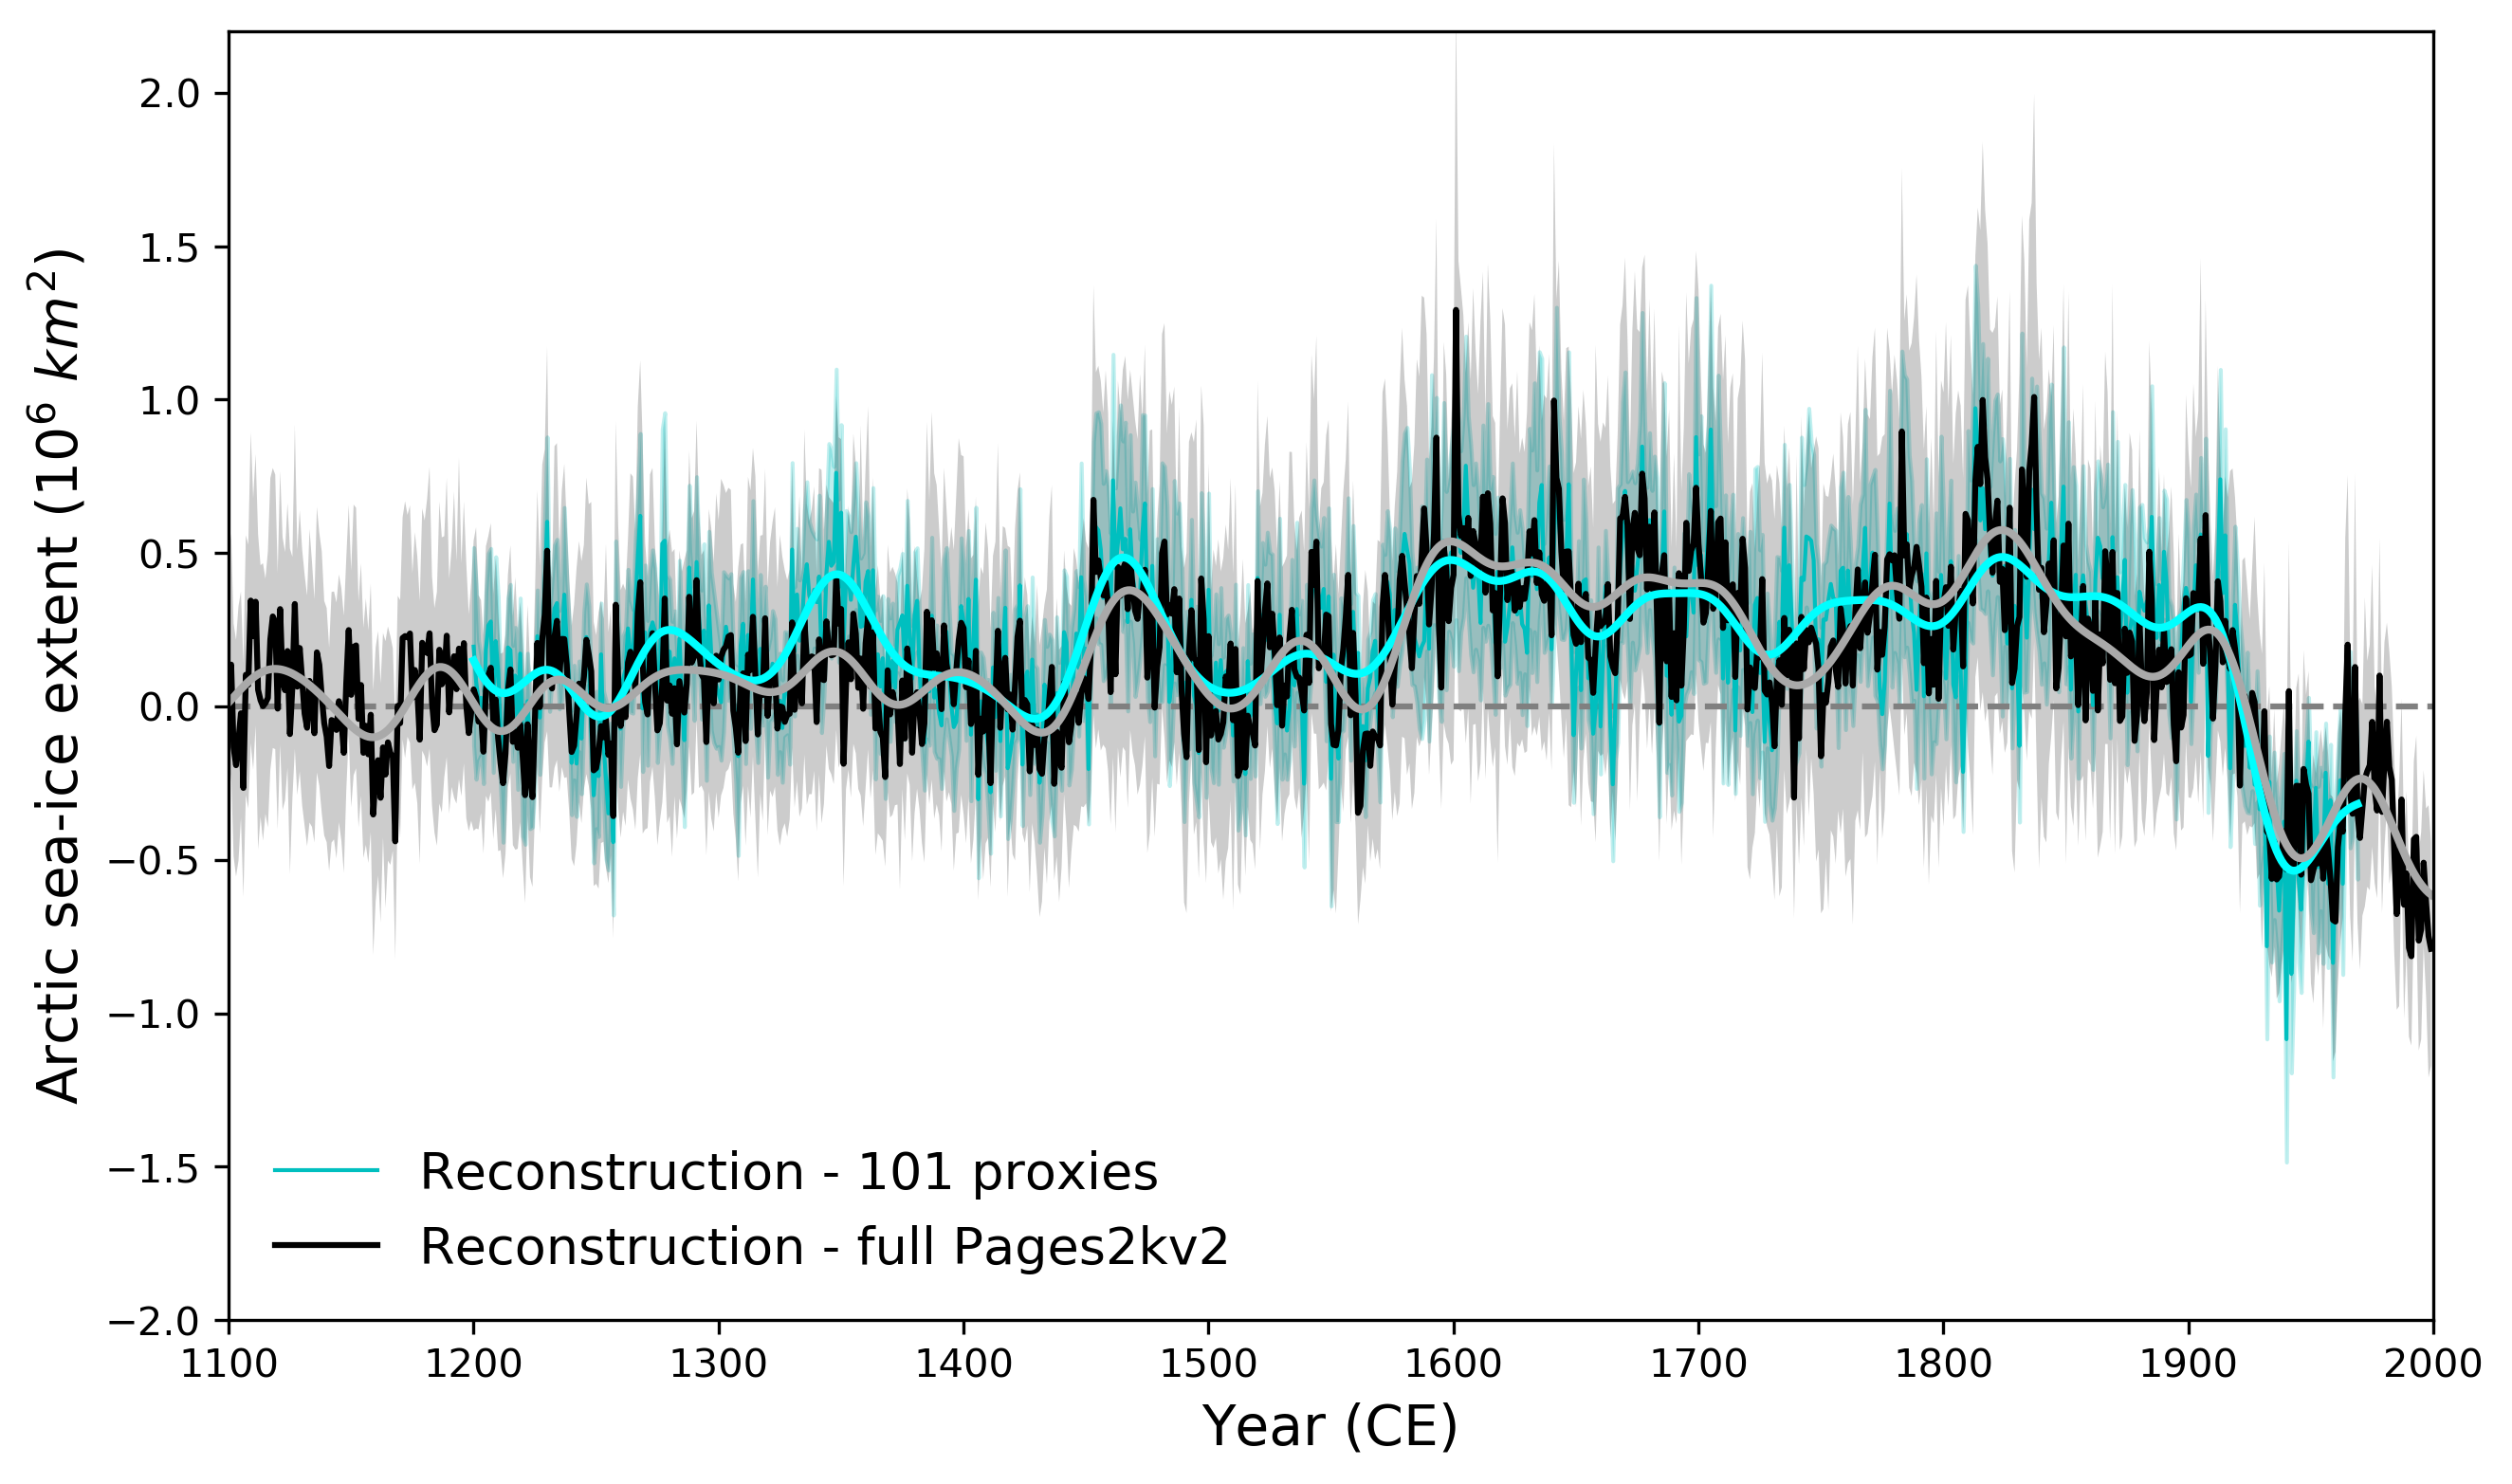

In [10]:
plt.figure(figsize=(10,6))
plt.axhline(0,linestyle='--',color='grey')

plt.fill_between(recon_years_fixed,sie_fixed_2_5_anom,sie_fixed_97_5_anom,
                 color='c',alpha=0.25)
plt.fill_between(recon_years,sie_ccsm4_2_5_anom_full, sie_ccsm4_97_5_anom_full,
                 color='k',alpha=0.2, linewidth=0.0)

plt.plot(recon_years_fixed,sie_ensmn_anom_fixed, label = 'Reconstruction - 101 proxies',
         color='c',linewidth=1.0)
plt.plot(recon_years,sie_ensmn_anom_ccsm4_full, label='Reconstruction - full Pages2kv2',
         color='k',linewidth=1.5)

plt.plot(recon_years_fixed,sie_f770_filt20,color='cyan',linewidth=2.0)
plt.plot(recon_years,sie_full_filt20,color='darkgray',linewidth=2)

plt.ylabel('Arctic sea-ice extent (10$^{6}$ $km^2$)',fontsize=14)
plt.xlabel('Year (CE)',fontsize=14)
#plt.title('Total Arctic Sea Ice Extent', fontsize=14)

plt.legend(fontsize=13,loc='lower left',frameon=False)#,bbox_to_anchor=(0.81, 0.22),frameon=False)
plt.ylim(-3,4,1)

plt.xlim(1100,2000)
plt.ylim(-2.0,2.2)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Fixed_proxy_full_timeseries_1100_2000.png'
#plt.savefig(savedir+savename)

## Figure 9: 

In [11]:
dt = 1
#time = np.arange(len(sst)) * dt + 1871.0  # construct time array

pad = 1  # pad the time series with zeroes (recommended)
dj =  0.125  # this will do 4 sub-octaves per octave
s0 = 2 * dt  # this says start at a scale of 6 months
j1 = 7 / dj  # this says do 7 powers-of-two with dj sub-octaves each
#lag1 = 0.59  # lag-1 autocorrelation for red noise background
#print("lag1 = ", lag1)
mother = 'DOG'
#mother = 'PAUL'
#mother = 'MORLET'
p = 1

In [12]:
lag1_f770 = calc_lac(sie_ensmn_anom_fixed[:-1],sie_ensmn_anom_fixed[1:])
lag1_full = calc_lac(sie_ensmn_anom_ccsm4_full[:-1],sie_ensmn_anom_ccsm4_full[1:])

lag1_full, lag1_f770

(0.760815356682638, 0.6654263501655744)

In [13]:
[period_f770, power_f770, 
 sig95_f770, coi_f770,
 time_f770] = get_cwt(sie_ensmn_anom_fixed,recon_years_fixed,
                      dt,pad,dj,s0,j1,mother,lag1_f770,param=p)

[period_full, power_full, 
 sig95_full, coi_full,
 time_full] = get_cwt(sie_ensmn_anom_ccsm4_full,recon_years,
                      dt,pad,dj,s0,j1,mother,lag1_full,param=p)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


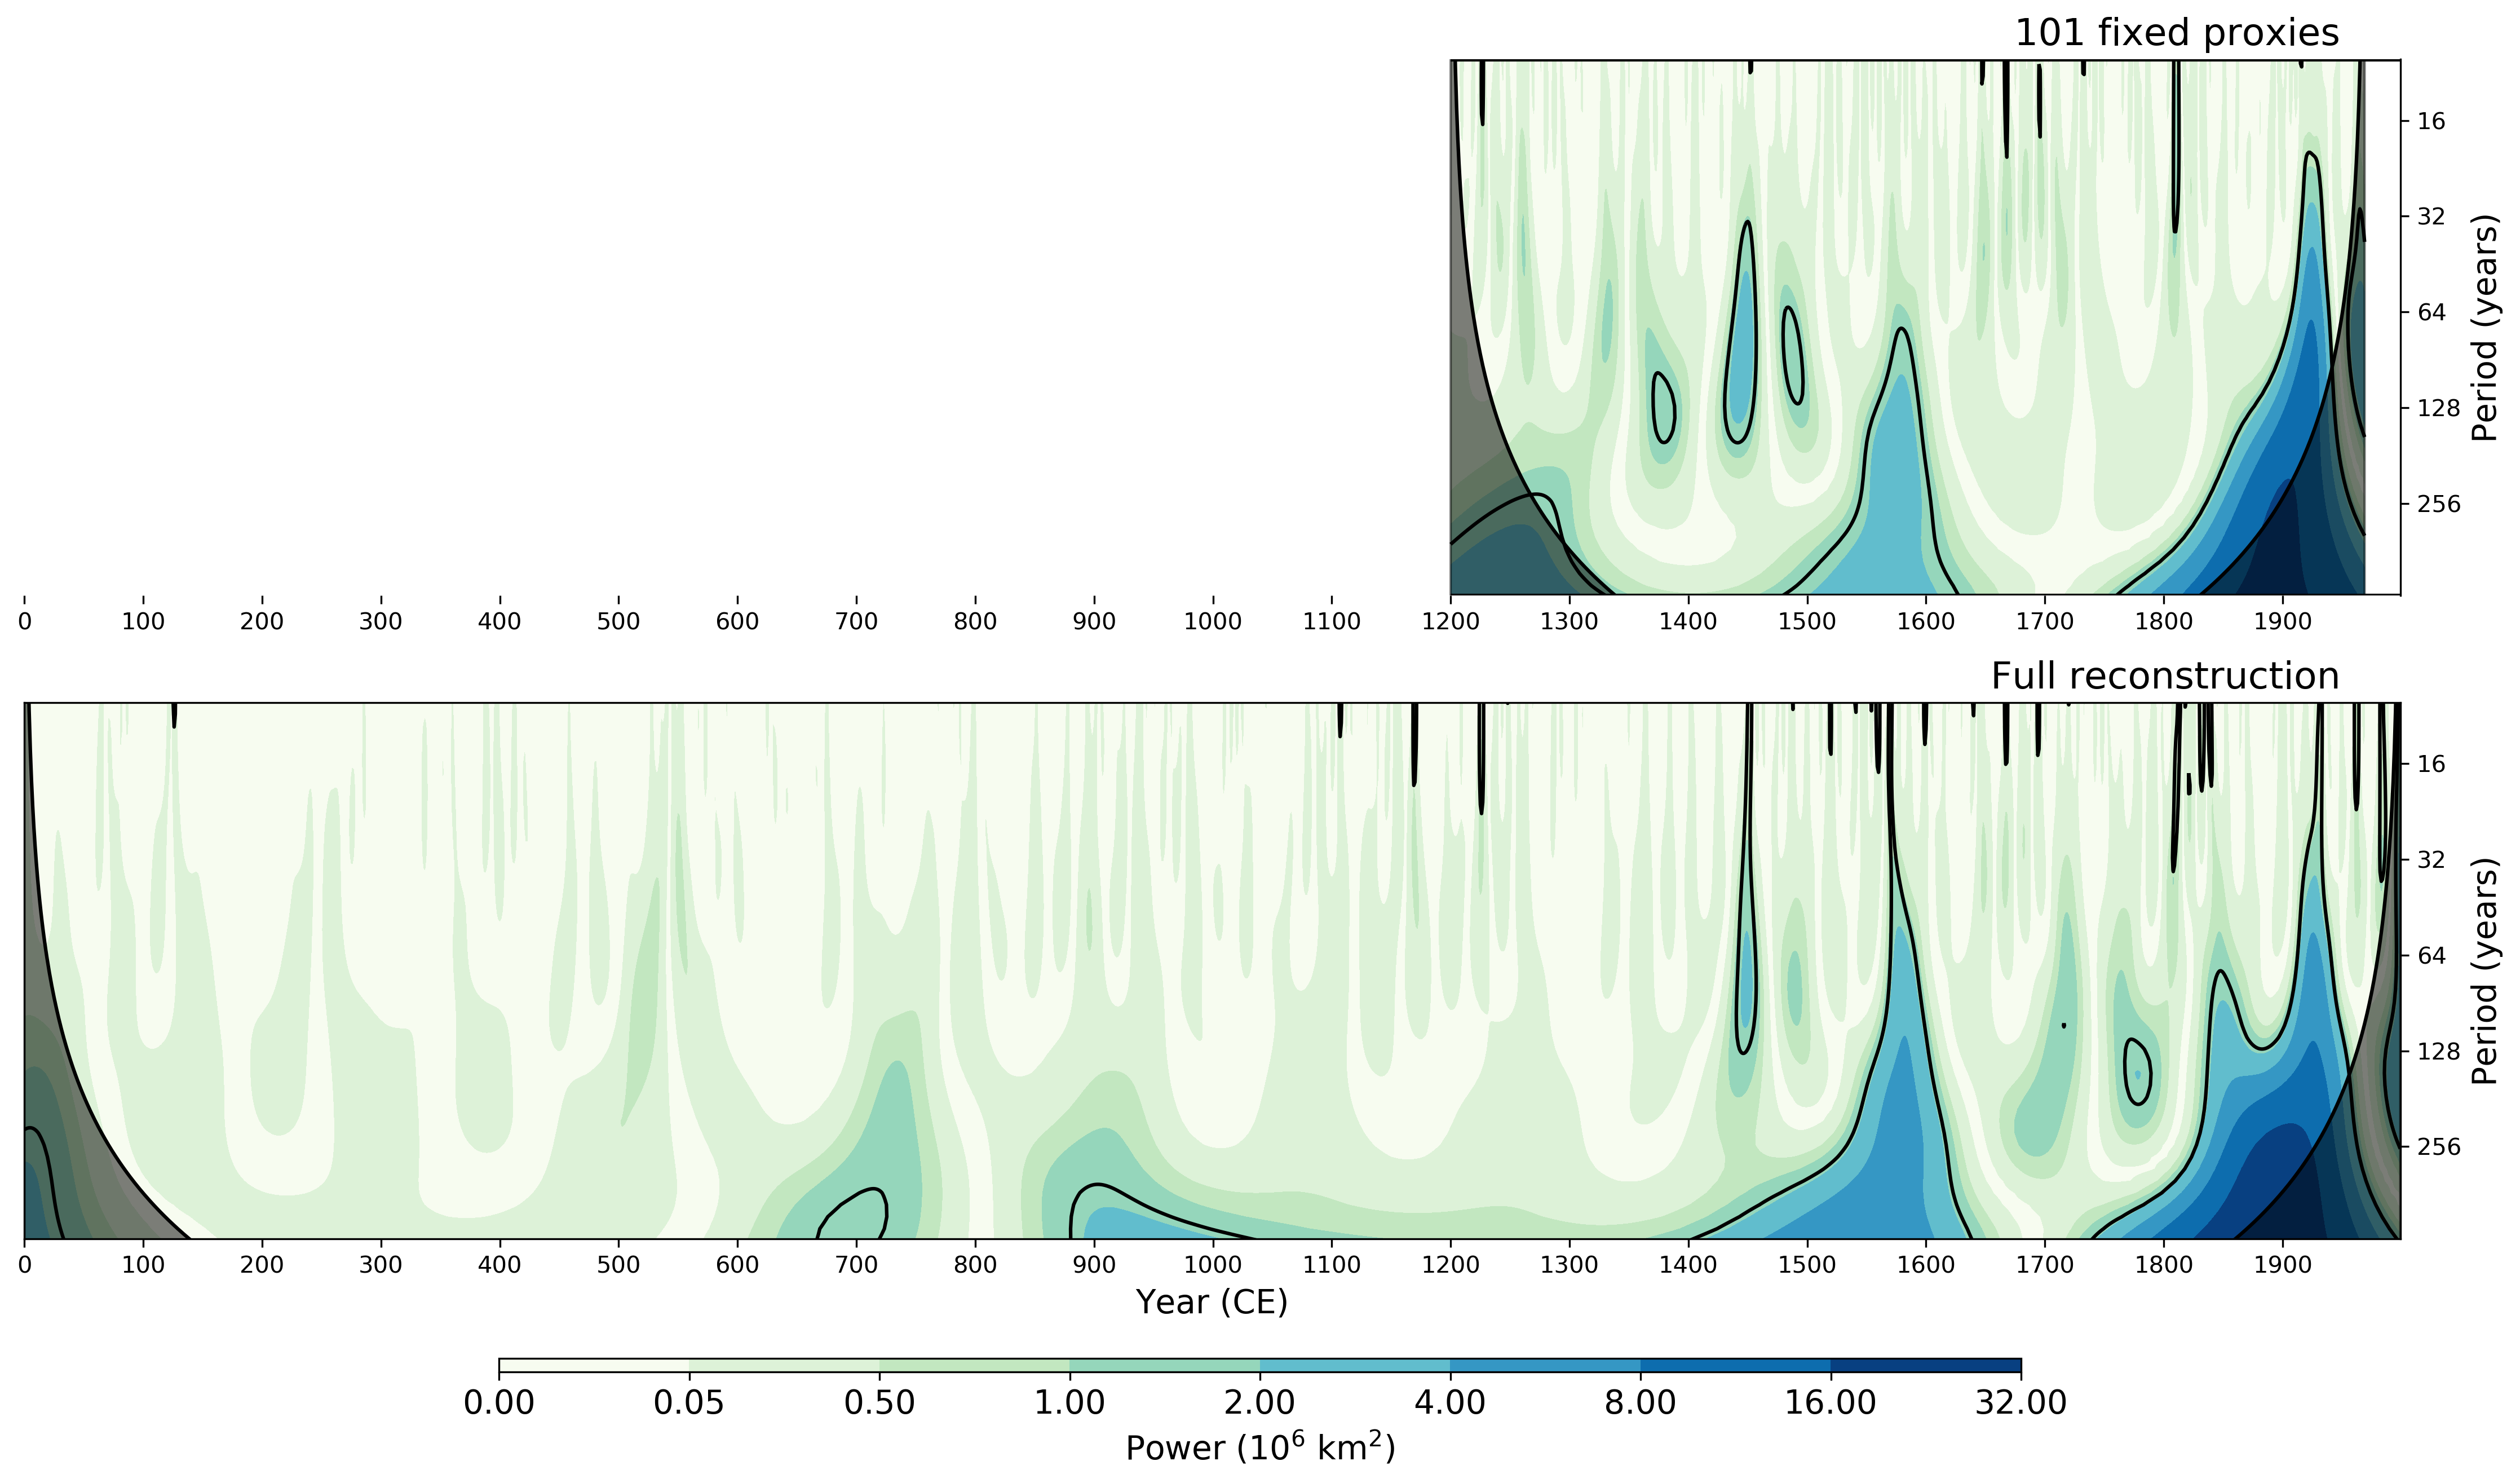

In [14]:
fig, ax = plt.subplots(2,1,figsize=(15, 8), sharex=True)
ax = ax.flatten()
levels = [10-10,0.05,0.5,1,2,4,8,16,32]
title_f400 = '134 fixed proxies     '
title_f770 = '101 fixed proxies     '
title_full = 'Full reconstruction     '

ax[0].set_xticks(np.arange(0,2000,100))
ax[1].set_xticks(np.arange(0,2000,100))

ax[0].xaxis.set_tick_params(which='both', labelbottom=True)

im = plot_cwt(fig, ax[0], time_f770, period_f770, power_f770, sig95_f770, coi_f770, title_f770, 
              levels=levels, cmap='GnBu')
im = plot_cwt(fig, ax[1], time_full, period_full, power_full, sig95_full, coi_full, title_full,
              levels=levels, cmap='GnBu')

ax[1].set_xlabel('Year (CE)', fontsize=14)

#ax[2].set_frame_on(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)

ax[0].hlines(10.3,1200,2000,color='k')
ax[0].hlines(500,1200,2000,color='k')

ax[0].yaxis.set_label_position("right")
ax[0].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()

# set up the size and location of the colorbar
position=fig.add_axes([0.2,-0.02,0.6,0.01])
cb = plt.colorbar(im, cax=position, orientation='horizontal') #, fraction=0.05, pad=0.5)
cb.ax.tick_params(labelsize=14)
cb.set_label("Power (10$^6$ km$^2$)", fontsize=14)

plt.xticks(fontsize=14)
plt.subplots_adjust(right=0.7, top=0.9)
plt.tight_layout()

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'cw_analysis_DOG1_f770_full_sharex.png'
#plt.savefig(savedir+savename, bbox_inches='tight')